In [1]:
import yfinance as yf

# Download data
gs = yf.download("AAPL", start="2013-10-01", end="2023-09-30")

[*********************100%%**********************]  1 of 1 completed


In [2]:
import pandas as pd
# Preprocess data
dataset_ex_df = gs.copy()
dataset_ex_df = dataset_ex_df.reset_index()
dataset_ex_df['Date'] = pd.to_datetime(dataset_ex_df['Date'])
dataset_ex_df.set_index('Date', inplace=True)
dataset_ex_df = dataset_ex_df['Close'].to_frame()

**ARIMA MODEL**

In [3]:
from pmdarima.arima import auto_arima

# Auto ARIMA to select optimal ARIMA parameters
model = auto_arima(dataset_ex_df['Close'], seasonal=False, trace=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9802.998, Time=5.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9842.030, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9840.349, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9840.108, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9843.244, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9841.104, Time=3.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9841.070, Time=1.83 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=9835.777, Time=7.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=9833.241, Time=11.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9839.532, Time=1.51 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9832.834, Time=3.87 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9842.609, Time=2.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=9843.879, Time=13.86 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=9845.076, Time=1.46 sec

Best model:  ARIMA(2,1,2)(0,0,

In [4]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    yhat = output[0]
    return yhat

# Split data into train and test sets
X = dataset_ex_df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

In [14]:
dataset_ex_df.shape

(2517, 1)

In [13]:
X.shape

(2517, 1)

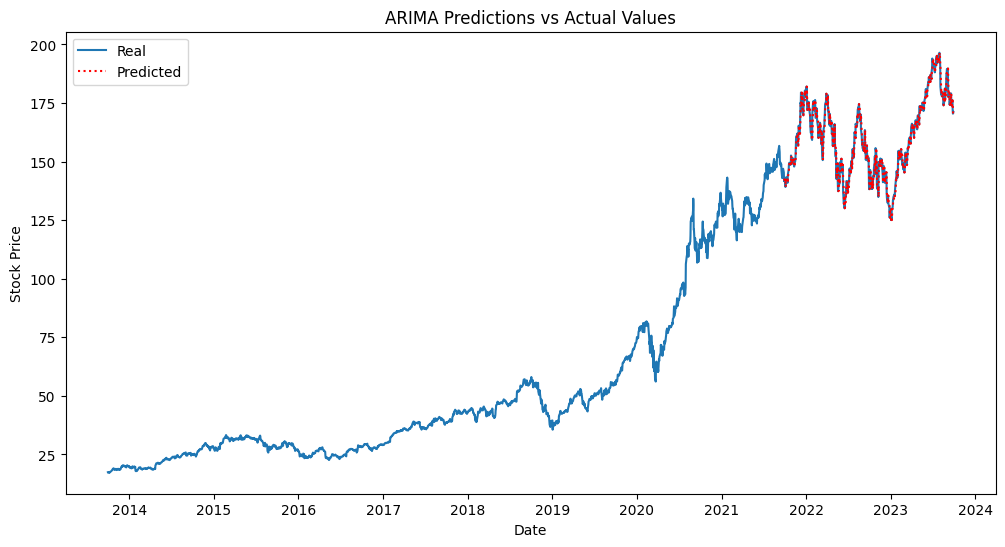

ARIMA Model - MSE: 8.50372283894542, RMSE: 2.916114339141286


In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(dataset_ex_df.index, X, label='Real')
plt.plot(dataset_ex_df.iloc[size:,:].index, predictions, color='red', label='Predicted',linestyle = 'dotted')
plt.title('ARIMA Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

from sklearn.metrics import mean_squared_error

mse_arima = mean_squared_error(test, predictions)
rmse_arima = np.sqrt(mse_arima)
print(f'ARIMA Model - MSE: {mse_arima}, RMSE: {rmse_arima}')

**GARCH MODEL**

In [ ]:
from arch import arch_model

# Fetching the stock data
ticker = "AAPL"
data = yf.download(ticker, start="2013-10-01", end="2023-09-30")

# Preprocessing the data
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)
data = data[['Date', 'Close']]

# Calculate daily returns
data['Return'] = data['Close'].pct_change().dropna() * 100

# Drop NaN values resulting from the percentage change calculation
data = data.dropna()

# Fit a GARCH(1,1) model
returns = data['Return']
model = arch_model(returns, vol='Garch', p=1, q=1)
model_fit = model.fit(disp='off')

# Forecasting
forecast_horizon = 5
forecast = model_fit.forecast(horizon=forecast_horizon)
mean_forecast = forecast.mean['h.1'].iloc[-1]
variance_forecast = forecast.variance['h.1'].iloc[-1]
print(f"Mean forecast: {mean_forecast}")
print(f"Variance forecast: {variance_forecast}")
data['Mean_Forecast'] = mean_forecast

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(data['Date'][0:2000], data['Return'][0:2000], label='Training Data')
plt.plot(data['Date'][2000:], data['Return'][2000:], label='Actual Returns')
plt.plot(data['Date'][2000:],data['Mean_Forecast'][2000:], label='GARCH Forecast')
plt.xlabel('Date')
plt.ylabel('Daily Returns (%)')
plt.title(f'{ticker} Daily Returns')
plt.tight_layout()
plt.legend()
plt.show()

# Evaluating the model
mse_garch = np.square(np.mean(mean_forecast-returns.mean()))
rmse_garch = np.sqrt(mse_garch)
print(f'GARCH Model - MSE: {mse_garch}, RMSE: {rmse_garch}')

**LSTM MODEL**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(gs['Close'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(scaled_data[:len(train)], time_step)
X_test, y_test = create_dataset(scaled_data[len(train):], time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(100, return_sequences=True, input_shape=(time_step, 1)))
lstm_model.add(LSTM(100, return_sequences=False))
lstm_model.add(Dense(250))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_model.fit(X_train, y_train, batch_size=1, epochs=1)

# Predicting and inverse scaling
train_predict = lstm_model.predict(X_train)
test_predict = lstm_model.predict(X_test)

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(gs.index, gs['Close'], label='Actual Prices')
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.plot(gs.index, train_predict_plot, label='LSTM Training Prediction')
plt.plot(gs.index, test_predict_plot, label='LSTM Testing Prediction')
plt.title('LSTM Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

# Evaluating the model
mse_lstm = mean_squared_error(gs['Close'][len(train_predict) + (time_step * 2) + 2:], test_predict)
rmse_lstm = np.sqrt(mse_lstm)
print(f'LSTM Model - MSE: {mse_lstm}, RMSE: {rmse_lstm}')

**FACEBOOK PROPHET**

In [ ]:
from prophet import Prophet

# Prepare the data for Prophet
prophet_data = gs['Close'].reset_index()
prophet_data.columns = ['ds', 'y']

# Split the data
train_prophet = prophet_data[prophet_data['ds'] <= '2022-09-30']
test_prophet = prophet_data[prophet_data['ds'] > '2022-09-30']

# Fit the Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train_prophet)

# Make future dataframe for predictions
future_dates = prophet_model.make_future_dataframe(periods=len(test_prophet))
forecast = prophet_model.predict(future_dates)

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))
prophet_model.plot(forecast, ax=ax)
ax.plot(test_prophet['ds'], test_prophet['y'], label='Actual Prices', color='red', linewidth=2)
plt.title('Facebook Prophet Model Forecast')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

# Evaluating the model
mse_prophet = mean_squared_error(gs['Close'], forecast['trend_upper'])
rmse_prophet = mse_prophet ** 0.5
print(f'Prophet Model - MSE: {mse_prophet}, RMSE: {rmse_prophet}')

**Comparison of Models**

In [ ]:
# Comparing the MSE and RMSE of all models
models = ['ARIMA', 'LSTM', 'Prophet']
mse_values = [mse_arima, mse_lstm, mse_prophet]
rmse_values = [rmse_arima, rmse_lstm, rmse_prophet]

# Plotting the MSE and RMSE values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(models, mse_values, color='skyblue')
plt.title('MSE Comparison')
plt.ylabel('MSE')

plt.subplot(1, 2, 2)
plt.bar(models, rmse_values, color='lightgreen')
plt.title('RMSE Comparison')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()